<a href="https://colab.research.google.com/github/brianbaert/MscThesis/blob/main/MscThesis_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [1]:
!python --version
#!pip install avalanche_lib[all]
#!pip install gwpy
#!pip install nds2
#!pip show avalanche-lib
#!pip show gwpy

Python 3.10.14


In [2]:
#%cd /content/drive/MyDrive/MscThesis
%pwd

'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis'

In [3]:
import numpy as np
import os
import pandas as pd
import time

from datetime import datetime
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
accuracy_score
from avalanche.models import SlimResNet18, MTSlimResNet18, SimpleCNN
from avalanche.models import as_multitask, IncrementalClassifier
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.training import Naive, LwF, GenerativeReplay, ICaRLLossPlugin, ICaRL, EWC, AR1, LFL, AGEM
from avalanche.logging import InteractiveLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin, LwFPlugin, EarlyStoppingPlugin, AGEMPlugin
from avalanche.training.plugins.lr_scheduling import LRSchedulerPlugin
from avalanche.benchmarks import nc_benchmark, ni_benchmark
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix,disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics, bwt_metrics, forward_transfer_metrics
import multiprocessing as mp

import my_utils
import my_architectures
import my_dataloaders
import my_gwpy_and_fractals
import my_transformations

IMG_SIZE = (224,224)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# calculating the amount of workers usable
number_of_workers = mp.cpu_count()
number_of_workers = int(number_of_workers/2)
print(number_of_workers)

4


In [5]:
# Setting the correct directories
train_dir2 = 'C:\\Users\\Brian.Baert\\TrainingSet'
train_dir = 'C:\\Users\\Brian.Baert\\GravitySpy\\train\\train'
val_dir = 'C:\\Users\\Brian.Baert\\GravitySpy\\validation\\validation'
test_dir = 'C:\\Users\\Brian.Baert\\GravitySpy\\test\\test'

# Read in class labels
class_file = open("classes.txt", "r")
classes = class_file.read()
classes = classes.split(", ")

# Read in inverse weights used to cope with the imbalanced dataset
class_weights_file = open("class_weights.txt", "r")
temp = class_weights_file.read()
temp_split = temp.split(", ")
class_weights =  [float(weight) for weight in temp_split]

In [ ]:
meta_train_v1 = pd.read_csv('C:\\Users\\Brian.Baert\\GravitySpy\\trainingset_v1d1_metadata.csv')
print(meta_train_v1[meta_train_v1['sample_type']=='train']['label'].value_counts())
classes = meta_train_v1['label'].unique()

# DL Baseline

In [105]:
train_set = my_dataloaders.GravitySpy_1_0_dataset(root=train_dir, cls=classes, transform=my_transformations.transformGray)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)
val_set = my_dataloaders.GravitySpy_1_0_dataset(root=val_dir, cls=classes, transform=my_transformations.transformGray)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=number_of_workers)
test_set = my_dataloaders.GravitySpy_1_0_dataset(root=test_dir, cls=classes, transform=my_transformations.transformGray)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

In [106]:
train_set = my_dataloaders.GravitySpy_0_5_dataset(root=train_dir, cls=classes, transform=my_transformations.transformGray)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)
val_set = my_dataloaders.GravitySpy_0_5_dataset(root=val_dir, cls=classes, transform=my_transformations.transformGray)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True)
test_set = my_dataloaders.GravitySpy_0_5_dataset(root=test_dir, cls=classes, transform=my_transformations.transformGray)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

In [ ]:
print("The training loader contains {} instances, the val loader contains {} instances and the test loader contains {} instances".format(len(train_loader), len(val_loader), len(test_loader)))

In [ ]:
class_counts = train_set.count_class_instances()
class_weights = []
for class_name, count in class_counts.items():
  print(f"{class_name}: {count} instances")
  class_weights.append(1.0/(count/len(train_set)))

class_weights

with open("class_weights.txt", "w") as output:
    output.write(str(class_weights))

In [ ]:
# Create Neural Network architecture for finetuning
myNet = my_architectures.BaselineGrayscaleNet_resnet18()
myNet.to(device)
print(myNet)

In [ ]:
# Pytorch Training loop
epoch_test_loss = 0
epoch_test_acc = 0
epoch_test_correct = 0
epoch_test_total = 0
best_vloss = 1_000_000.
avg_loss = 0
last_loss = 0
timestamp = my_utils.get_timestamp()

# Define the loss function and optimizer
criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)
optimizer = Adam(myNet.parameters(), lr=0.001, weight_decay=1e-3) #LR from the study of Tiago Fernandes

# Number of epochs to train for
num_epochs = 10
epoch_number = 0

start = time.time()
for epoch in range(num_epochs):  # loop over the dataset multiple times
  total_correct = 0
  total_samples = 0
  print('EPOCH {}: '.format(epoch_number + 1))
  train_loss = 0.0
  myNet.train(True)

  ## TRAINING ONE EPOCH
  for i, data in enumerate(train_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = myNet(inputs)
    # compute loss and gradient
    loss = criterion(outputs, labels)
    #add part of regularization
    l2_reg = torch.tensor(0.0)
    for param in myNet.parameters():
      if param.requires_grad: #exclude frozen layers
        l2_reg += torch.norm(param, p=2)
    loss += 1e-5 * l2_reg
    #end part of regularization
    loss.backward()
    # adjust learning weights
    optimizer.step()

    # print statistics
    _, predicted = torch.max(outputs, 1)
    train_loss += loss.item()
    total_correct += (predicted == labels).sum().item()
    total_samples += labels.size(0)

    if i % 16 == 15:
      last_loss = train_loss / 16
      print('  batch {} loss: {}, acc: {}'.format(i+1, last_loss, 100*total_correct/total_samples))
      tb_x = epoch * len(train_loader) + i + 1
      train_loss=0.
    avg_loss = last_loss

  ## VALIDATION
  running_vloss = 0.0
  myNet.eval()

  # disable gradient computation for validation
  with torch.no_grad():
    for i, vdata in enumerate(val_loader):
      vinputs, vlabels = vdata
      vinputs, vlabels = vinputs.to(device), vlabels.to(device)
      voutputs = myNet(vinputs)
      vloss = criterion(voutputs, vlabels)
      running_vloss += vloss
  avg_vloss = running_vloss / (i+1)
  print('LOSS train {:.4f} valid {:.4f} after {} seconds'.format(avg_loss, avg_vloss, time.time()-start))

  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    torch.save(myNet.state_dict(), model_path)

  #my_utils.checkpoint(myNet, f"epoch-{epoch}.pth")
  epoch_number += 1

end = time.time()
print('Training finished after ', end-start, ' seconds')

In [ ]:
#save model
#torch.save(myNet.state_dict(), '/content/drive/MyDrive/MscThesis/thesis_baseline_finetune_0_5.pth')
torch.save(myNet.state_dict(), 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_baseline_finetune_0_5.pth')
print("Saved Pytorch Model state to thesis_baseline.pth")

In [ ]:
#myNet.load_state_dict(torch.load('/content/drive/MyDrive/MscThesis/thesis_baseline_finetune_1_0.pth'))
myNet.load_state_dict(torch.load('C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_baseline_finetune_1_0.pth'))

In [ ]:
my_utils.n_test_predictions(myNet, test_loader, classes, 20)

In [ ]:
y_pred_list, y_true_list = my_utils.get_predictions(myNet, test_loader)

In [ ]:
# Generate confusion matrix
from sklearn.metrics import f1_score
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))

# Use seaborn heatmap for visualization
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
figTemp = plt.gcf()
plt.show()
plt.draw()
figTemp.savefig('confusion_matrix_baseline_1_0.png')
plt.close()

In [ ]:
print(f"F1 Score for each class: {f1}")
print(f"The average F1 score is: {f1_score(y_true_list, y_pred_list, average='weighted')}")

In [ ]:
# Create a horizontal bar plot for F1 scores with different colors
plt.figure(figsize=(10,7))
colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
plt.barh(np.arange(len(classes)), f1, color=colors, align='center', alpha=0.5)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('F1 Score')
plt.title('F1 Score for Each Class')
figTemp = plt.gcf()
plt.show()
plt.draw()
figTemp.savefig('f1_scores_baseline_1_0.png')
plt.close()

# CL Experiments

# 1) CLASS INCREMENTAL

## Model, dataloader, benchmark and eval plugin

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = my_architectures.BaselineColorNet_resnet18()
model.to(device)

classes = my_utils.get_classes_from_dir(train_dir2)
class_to_indx = my_utils.classes_to_indices(classes)

In [11]:
train_set = my_dataloaders.GravitySpy_2_0_dataset(root=train_dir, cls=classes, transform=my_transformations.transformAV_224_Crop)
val_set = my_dataloaders.GravitySpy_2_0_dataset(root=val_dir, cls=classes, transform=my_transformations.transformAV_224)
test_set = my_dataloaders.GravitySpy_2_0_dataset(root=test_dir, cls=classes, transform=my_transformations.transformAV_224)

train_set_av = AvalancheDataset(train_set)
train_loader_av = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

val_set_av = AvalancheDataset(val_set)
val_loader_av = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

test_set_av = AvalancheDataset(test_set)
test_loader_av = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

train_set_av.targets = train_set.labels
test_set_av.targets = test_set.labels
val_set_av.targets = val_set.labels

train_set_av.uniques = list(set(train_set.labels))
test_set_av.uniques = list(set(test_set.labels))
val_set_av.uniques = list(set(val_set.labels))

In [101]:
# DEFINE THE BENCHMARK
# CL custom benchmark, here we opt for the generator New Classes (NC)
# Given a sequence of train and test datasets this creates the continual stream as a series of experiences.
bm = nc_benchmark(
    train_dataset=train_set_av,
    test_dataset=val_set_av,
    n_experiences=11,
    shuffle=True,
    seed=1234,
    task_labels=False,
    class_ids_from_zero_in_each_exp=False,
)

In [103]:
# DEFINE THE EVALUATION PLUGIN
# The evaluation plugin manages the metrics computation. It takes as argument a list of metrics, collectes their results and returns
# them to the strategy it is attached to.

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=False, stream=True),
    bwt_metrics(experience=True, stream=True),
    forward_transfer_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()],
    strict_checks=False,
)

In [50]:
#model.to(device)
#interactive_logger = InteractiveLogger()

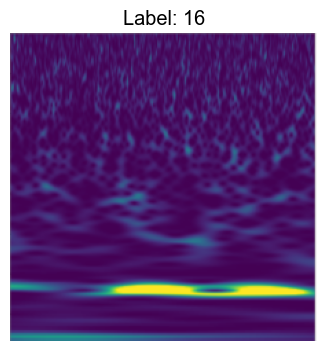

In [107]:
my_utils.plot_first_image(train_loader_av)

In [ ]:
my_utils.plot_first_image(val_loader_av)

In [ ]:
my_utils.plot_first_image(test_loader_av)

## Naive strategy with cross entropy loss and adam

In [85]:
# OPTIMIZER and CRITERION
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)

In [86]:
# NAIVE STRATEG
cl_strategy = Naive(
    model=model, optimizer=optimizer, criterion=criterion, train_mb_size=32, train_epochs=20, 
    eval_mb_size=16, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_set)), EarlyStoppingPlugin(patience=2, val_stream_name='valid')]
)

In [87]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.Naive object at 0x0000029FA17A3B50>
Start of experience:  0
Current Classes:  [19, 5]
2
-- >> Start of training phase << --
100%|██████████| 4/4 [00:14<00:00,  3.67s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.2374
	Loss_MB/train_phase/train_stream/Task000 = 3.8083
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4300
100%|██████████| 4/4 [00:14<00:00,  3.58s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.5067
	Loss_MB/train_phase/train_stream/Task000 = 3.3116
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9500
100%|██████████| 4/4 [00:15<00:00,  3.86s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.1909
	Loss_MB/train_phase/train_stream/Task000 = 2.9564
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9800
100%|██████████| 4/4 [00:15<00:00,  3.83s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.1963
	Loss

In [88]:
# SAVE MODEL
my_utils.checkpoint(model, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_Naive_CL_1_0.pth')

Saved Pytorch model state to  C:\Users\Brian.Baert\Documents\GitHub\MscThesis\Models\thesis_Naive_CL_1_0.pth


In [89]:
# SOME TEST PREDICTIONS
my_utils.n_test_predictions(model, test_loader_av, classes, 20)

Predicted: "Scattered_Light", Actual: "Scattered_Light"
Predicted: "Whistle", Actual: "Blip"
Predicted: "No_Glitch", Actual: "Blip"
Predicted: "Repeating_Blips", Actual: "Blip"
Predicted: "Repeating_Blips", Actual: "Blip"
Predicted: "1400Ripples", Actual: "Whistle"
Predicted: "Whistle", Actual: "Light_Modulation"
Predicted: "Extremely_Loud", Actual: "Light_Modulation"
Predicted: "Helix", Actual: "Light_Modulation"
Predicted: "Repeating_Blips", Actual: "Repeating_Blips"
Predicted: "No_Glitch", Actual: "Power_Line"
Predicted: "Koi_Fish", Actual: "Koi_Fish"
Predicted: "1400Ripples", Actual: "Violin_Mode"
Predicted: "No_Glitch", Actual: "Scattered_Light"
Predicted: "Extremely_Loud", Actual: "Extremely_Loud"
Predicted: "Koi_Fish", Actual: "Koi_Fish"
Predicted: "No_Glitch", Actual: "Low_Frequency_Burst"
Predicted: "Air_Compressor", Actual: "Low_Frequency_Burst"
Predicted: "Repeating_Blips", Actual: "Blip"
Predicted: "No_Glitch", Actual: "Blip"
n_test_predictions: 1555.8066368103027 ms


In [90]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

get_predictions: 80898.3199596405 ms


In [91]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

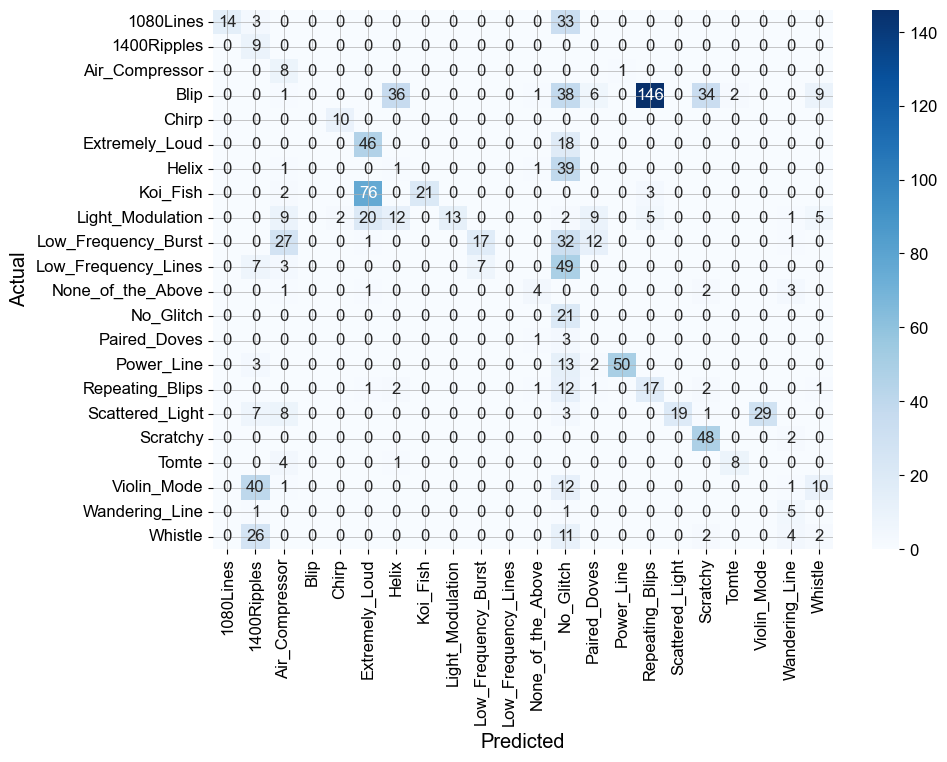

In [92]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'cm_Naive_1_0.png')

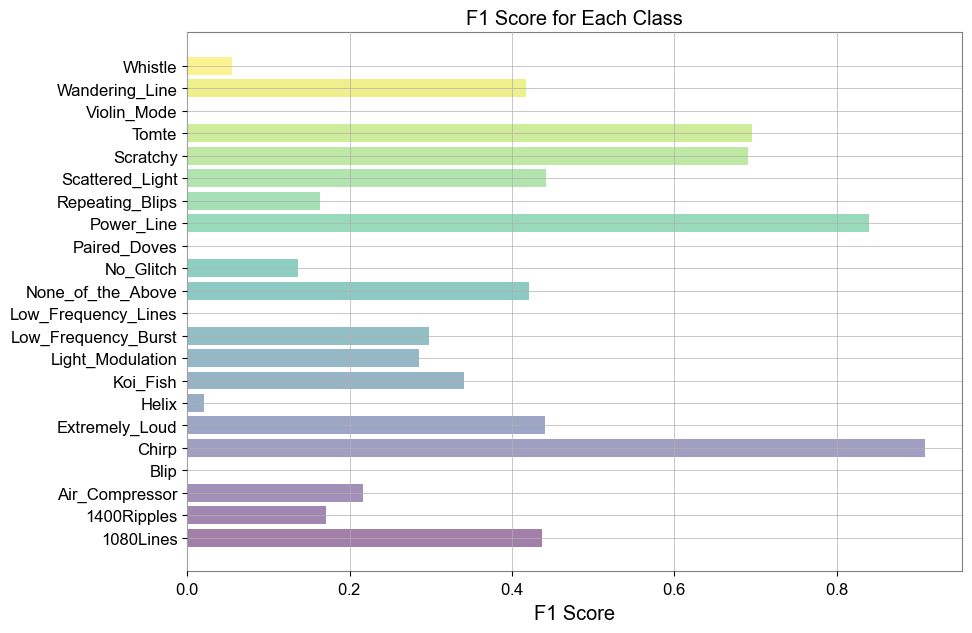

In [93]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'f1_scores_Naive_1_0.png')

## LwF strategy with cross entropy loss and adam optimizer
The experiments are done on a neural network starting with 2 output nodes and gradually adapting with each experience to 22, but also on a neural network with 22 output nodes and running over the experiences.

In [ ]:
# SETTING UP DEVICE AND INSTANCE OF MODEL CLASS
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = my_architectures.BaselineColorNet_resnet18()
model.to(device)

In [96]:
# OPTIMIZER and LOSS CRITERION
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)

In [97]:
# STRATEGY 
# ALPHA AND TEMPERATURE are taken from the paper by Oren & Wolf - "In defense of the Learning Without Forgetting for Task Incremental Learning"
cl_strategy = LwF(
    model=model, optimizer=optimizer, criterion=criterion, alpha=0.25, temperature=2.0, 
    train_mb_size=64, train_epochs=20, eval_mb_size=32, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_set))] #Early stopping is not used here because LwF does not inherently support Early Stopping
)

In [98]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.LwF object at 0x0000029FA5A7ED40>
Start of experience:  0
Current Classes:  [19, 5]
2
-- >> Start of training phase << --
100%|██████████| 2/2 [00:16<00:00,  8.07s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.4230
	Loss_MB/train_phase/train_stream/Task000 = 4.1822
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0500
100%|██████████| 2/2 [00:17<00:00,  8.64s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.8040
	Loss_MB/train_phase/train_stream/Task000 = 3.7426
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7600
100%|██████████| 2/2 [00:17<00:00,  8.67s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.4881
	Loss_MB/train_phase/train_stream/Task000 = 3.4131
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9300
100%|██████████| 2/2 [00:16<00:00,  8.14s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.2860
	Loss_M

In [99]:
# SAVE MODEL
my_utils.checkpoint(model, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_LwF_CL_1_0.pth')

Saved Pytorch model state to  C:\Users\Brian.Baert\Documents\GitHub\MscThesis\Models\thesis_LwF_CL_1_0.pth


In [100]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

get_predictions: 80857.90276527405 ms


In [101]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

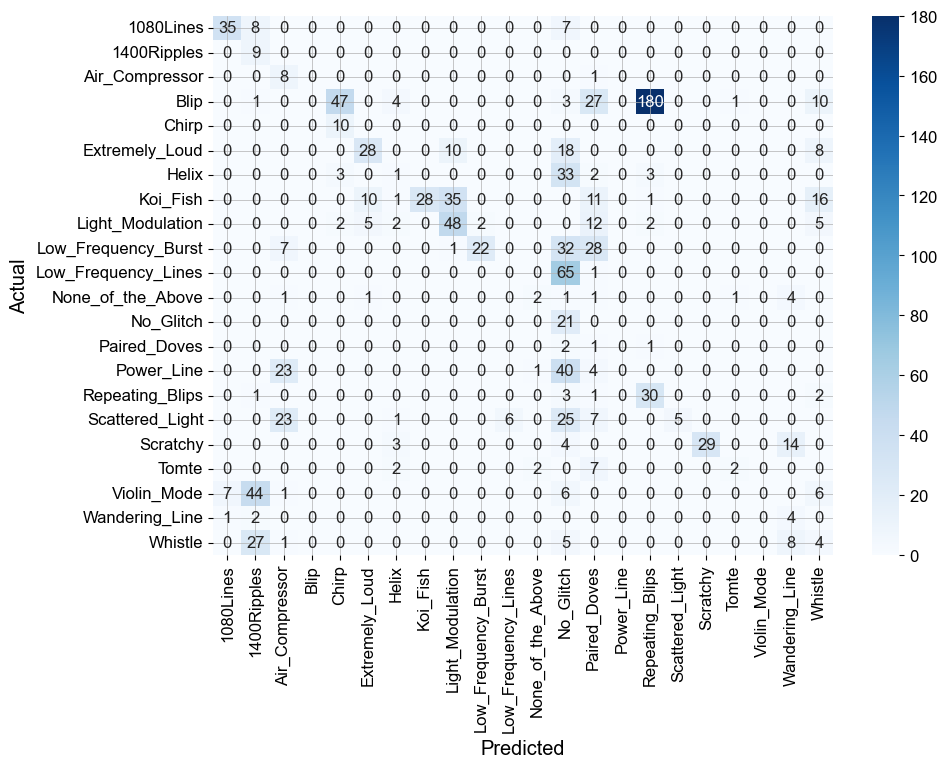

In [102]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'cm_LwF_1_0.png')

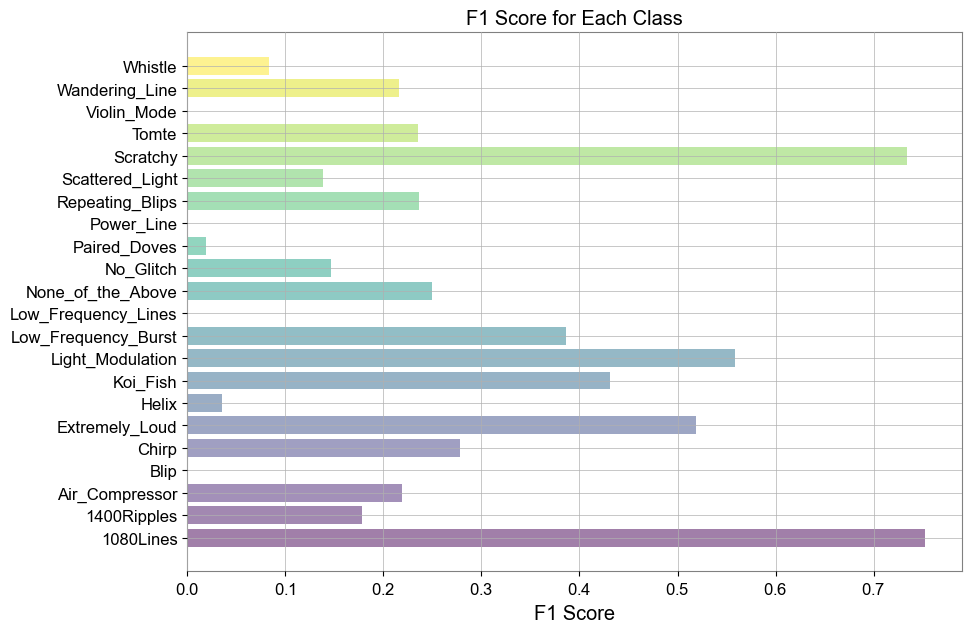

In [103]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'f1_scores_LwF_1_0.png')

According to Oren & Wolf ("In defense of the learning without forgetting for task incremental learning"), LwF mostly benefits from a Wide-ResNet netwrok rather than from deeper networks. 

## AGEM strategy with cross entropy loss and adam

In [ ]:
model = my_architectures.BaselineColorNet_resnet18()
model.to(device)

In [56]:
# OPTIMIZER AND LOSS CRITERION
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)

In [57]:
# STRATEGY
cl_strategy = AGEM(
    model=model, optimizer=optimizer, criterion=criterion, patterns_per_exp=11,
    train_mb_size=64, train_epochs=20, eval_mb_size=32, device=device, evaluator=eval_plugin,
    plugins=[ReplayPlugin(mem_size=2*len(train_set)), AGEMPlugin(patterns_per_experience=11, sample_size=64)]
)

In [58]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.AGEM object at 0x000001399A9F2A10>
Start of experience:  0
Current Classes:  [19, 5]
2
-- >> Start of training phase << --
100%|██████████| 2/2 [00:11<00:00,  5.70s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.3883
	Loss_MB/train_phase/train_stream/Task000 = 4.0992
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1700
100%|██████████| 2/2 [00:11<00:00,  5.78s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.7819
	Loss_MB/train_phase/train_stream/Task000 = 3.6672
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8200
100%|██████████| 2/2 [00:11<00:00,  5.92s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.4373
	Loss_MB/train_phase/train_stream/Task000 = 3.3234
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9600
100%|██████████| 2/2 [00:11<00:00,  5.99s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.1987
	Loss_

In [59]:
# SAVE MODEL
my_utils.checkpoint(model, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_AGEM_CL_1_0.pth')

Saved Pytorch model state to  C:\Users\Brian.Baert\Documents\GitHub\MscThesis\Models\thesis_AGEM_CL_1_0.pth


In [60]:
# CALCULATE PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

get_predictions: 108294.32082176208 ms


In [62]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

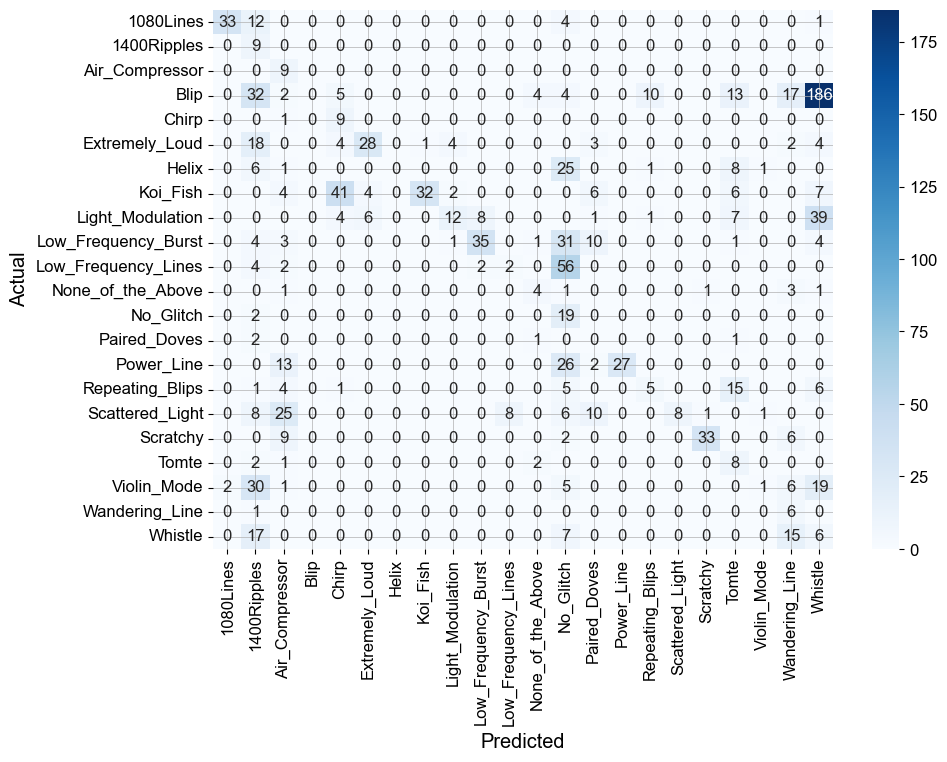

In [63]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'cm_adaptive_AGEM_1_0.png')

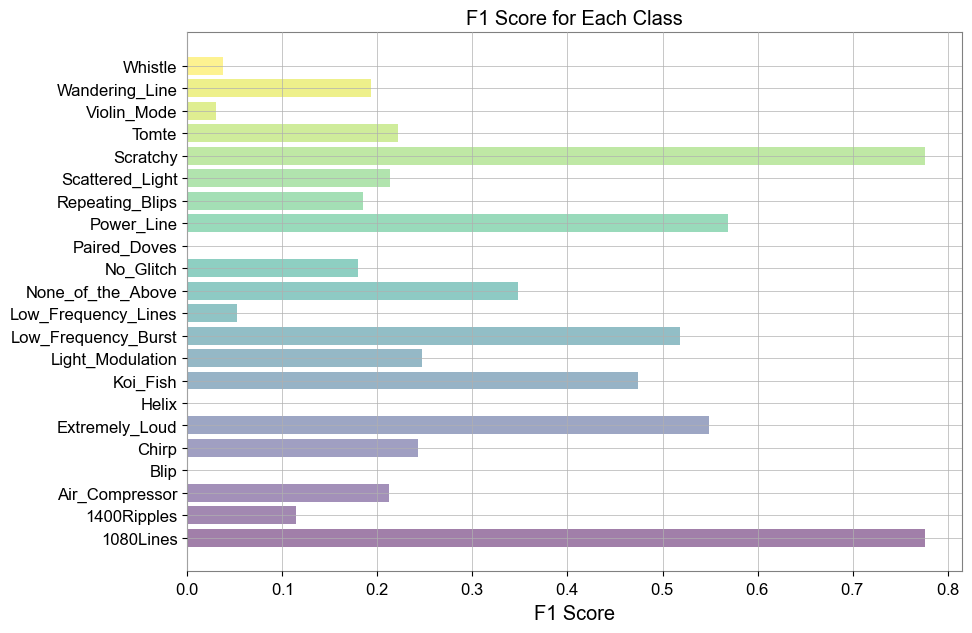

In [64]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'f1_adaptive_AGEM_1_0.png')

In [96]:
metric_dict = eval_plugin.get_all_metrics()
#for key in metric_dict.keys():
#    print(key)
metric_dict['Top1_Acc_Stream/eval_phase/train_stream/Task000']

([40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440],
 [1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0])

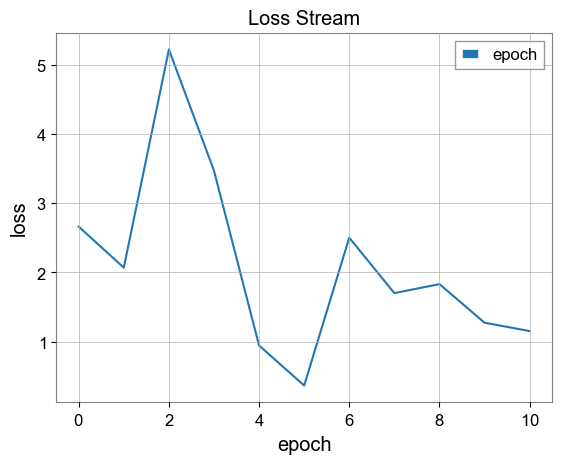

In [99]:
plt.clf()
plt.plot(metric_dict['Loss_Stream/eval_phase/train_stream/Task000'][1])
plt.title('Loss Stream')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['epoch'], loc='upper right')
plt.show()

## AR1 strategy with cross entropy loss and adam

In [ ]:
model = my_architectures.BaselineColorNet_resnet18()
model.to(device)

In [105]:
# LOSS CRITERION
# AR1 uses SGD, there is no option to change the optimizer
criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)

In [106]:
# AR1 STRATEGY
cl_strategy = AR1(criterion=CrossEntropyLoss(), lr=0.001, inc_lr=0.00005, init_update_rate = 0.01, train_epochs=20,
                  l2 = 0.0005, inc_update_rate = 0.00005, inc_step = 4.1e-05, rm_sz = 2*len(train_set), device=device)

C:\ProgramData\anaconda3\envs\MscThesis\lib\site-packages\avalanche\training\supervised\ar1.py:117: UserWarning: The AR1 strategy implementation is in an alpha stage and is not perfectly aligned with the paper implementation. Please use at your own risk!
  warnings.warn(


In [107]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers=4)

Starting experiment with strategy: <avalanche.training.supervised.ar1.AR1 object at 0x00000139AD87EF80>
Start of experience:  0
Current Classes:  [19, 5]
2
-- >> Start of training phase << --
100%|██████████| 1/1 [00:19<00:00, 19.32s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.9120
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
100%|██████████| 1/1 [00:22<00:00, 22.11s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.8418
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9600
100%|██████████| 1/1 [00:22<00:00, 22.80s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.6958
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9500
100%|██████████| 1/1 [00:23<00:00, 23.39s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.4560
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9300
100%|██████████| 1/1 [00:23<00:00, 23.41s/it]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.0638
	

In [108]:
# SAVE MODEL
my_utils.checkpoint(model, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_AR1_CL_2_0.pth')

Saved Pytorch model state to  C:\Users\Brian.Baert\Documents\GitHub\MscThesis\Models\thesis_AR1_CL_2_0.pth


In [109]:
# CALCULATE PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

get_predictions: 84889.74213600159 ms


In [110]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

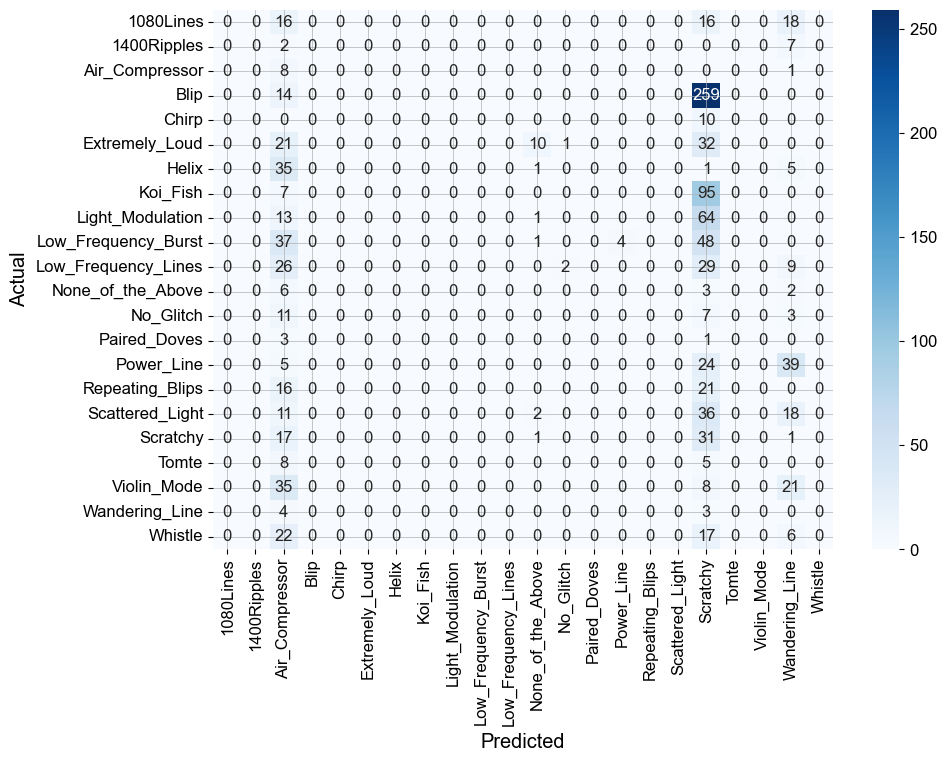

In [111]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'cm_AR1_2_0.png')

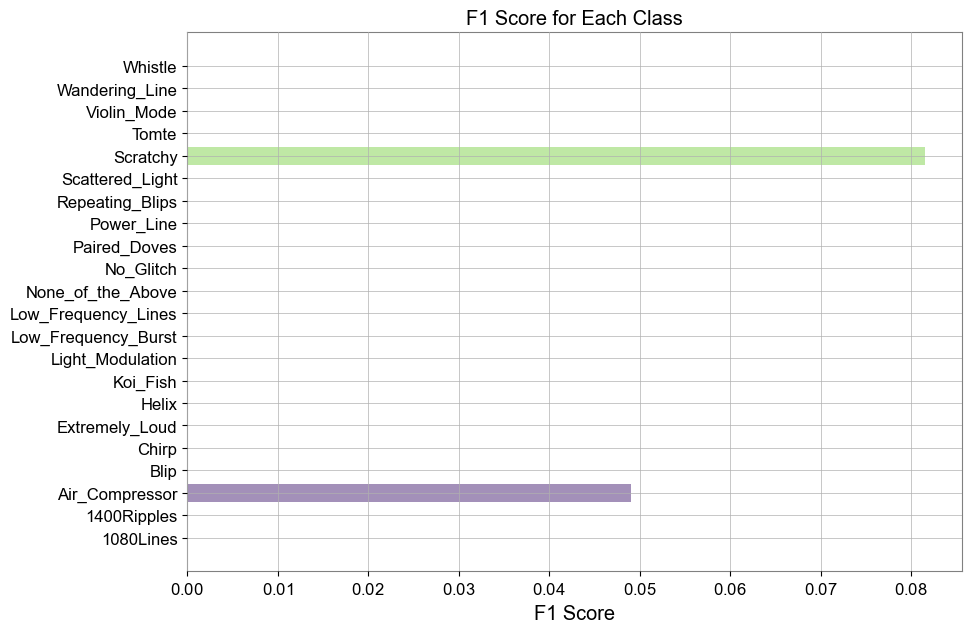

In [112]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'f1_AR1_2_0.png')

# TASK INCREMENTAL - Instance based

In [8]:
model = my_architectures.BaselineColorNet_resnet18()
model.to(device)

BaselineColorNet_resnet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [19]:
# DEFINE THE BENCHMARK
# CL custom benchmark, here we opt for the generator New Instances (NI)
# Given a sequence of train and test datasets this creates the continual stream as a series of experiences.
bm = ni_benchmark(
    train_dataset=train_set_av,
    test_dataset=val_set_av,
    n_experiences=11,
    shuffle=True,
    seed=1234,
    task_labels=False,
)

In [20]:
# DEFINE THE EVALUATION PLUGIN
# The evaluation plugin manages the metrics computation. It takes as argument a list of metrics, collectes their results and returns
# them to the strategy it is attached to.

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=False, stream=True),
    bwt_metrics(experience=True, stream=True),
    #forward_transfer_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()],
    strict_checks=False,
)

## Naive strategy with Adam and Cross Entropy Loss

In [21]:
# OPTIMIZER and CRITERION
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)

In [22]:
# NAIVE STRATEG
cl_strategy = Naive(
    model=model, optimizer=optimizer, criterion=criterion, train_mb_size=32, train_epochs=2, 
    eval_mb_size=16, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_set)), EarlyStoppingPlugin(patience=2, val_stream_name='valid')]
)

In [ ]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.Naive object at 0x000001DD9F18CF40>
Start of experience:  0
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
22
-- >> Start of training phase << --
100%|██████████| 16/16 [01:18<00:00,  4.92s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.5011
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8386
100%|██████████| 16/16 [01:33<00:00,  5.87s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.5138
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8504
-- >> End of training phase << --
Training completed
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 32/32 [00:38<00:00,  1.20s/it]
> Eval on experience 0 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp000 = 2.4949
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp000 = 0.93

In [ ]:
# SAVE MODEL
my_utils.checkpoint(model, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_TaskBased_Naive_CL_2_0.pth')

In [ ]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'cm_TaskBased_Naive_2_0.png')

In [ ]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'f1_TaskBased_Naive_2_0.png')